In [1]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..', '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga



Populating the interactive namespace from numpy and matplotlib


### Process indrops counts and build loompy objects

In [2]:
import stage5_timecourse
data_objs = {}

# This is the object for the inDrops processed data. In the same format as for the Stages 3-6 data. 
s5 = 'stage5_tc'
data_objs[s5] = stage5_timecourse.Stage5_timecourse('../data/indrops_intermediate')

import json
with open('../../01_Stages_3_to_6/data/original/cell_cycle_genes.json', 'r') as f:
    cell_cycle_gene_set = set(json.load(f))
    

In [3]:
%rm ../data/quality_filter/*.loom

counts = data_objs[s5].counts.values.T
cell_name = data_objs[s5].counts.index
cell_day = np.array([int(c[13]) for c in cell_name])
cell_flask = np.array([int(c[8]) for c in cell_name])
cell_batch = np.array([c.split('.')[0] for c in cell_name])
gene_name = data_objs[s5].counts.columns

min_cells_per_valid_gene = 10

loom_fn = f'../data/quality_filter/stage5.all_cells.raw.loom'
loompy.create(loom_fn, {'': counts},
                  {'Gene': gene_name,
                   '_Valid': (~np.isin(gene_name, list(cell_cycle_gene_set))) & (counts.sum(1).A.ravel() > min_cells_per_valid_gene),
                      },
                  {'CellID': cell_name,
                   '_Valid': np.ones(cell_name.shape).astype(int),
                   'CellDay': cell_day,
                   'CellFlask': cell_flask,
                   'CellBatch': cell_batch,
                      })

for dy in range(8):
    cell_filter = np.where(cell_day == dy)[0]
    loom_fn = f'../data/quality_filter/stage5.day{dy}.raw.loom'
    loompy.create(loom_fn, {'': counts[:, cell_filter]},
                      {'Gene': gene_name,
                       '_Valid': (counts[:, cell_filter].sum(1).A.ravel() > min_cells_per_valid_gene),
                          },
                      {'CellID': cell_name[cell_filter],
                       '_Valid': np.ones(cell_name[cell_filter].shape).astype(int),
                       'CellDay': cell_day[cell_filter], 
                       'CellFlask': cell_flask[cell_filter], 
                       'CellBatch': cell_batch[cell_filter], 
                        })
    



In [4]:
loom_fn = f'../data/quality_filter/stage5.all_cells.raw.loom'
ds = loompy.connect(loom_fn)
ds.vals = sp.sparse.csr_matrix(ds.layers[""][:, :])

In [5]:

tds = OrderedDict()
for tp in range(0,8):
    loom_fn = f'../data/quality_filter/stage5.day{tp}.raw.loom'
    tds[tp] = loompy.connect(loom_fn)
    tds[tp].vals = sp.sparse.csr_matrix(tds[tp].layers[""][:, :])
    

## 1. Quality filtering

### Automated filtering

In [8]:
# seed = 13501065

# for tp in tds.keys():
# #     cga.highvar_pca(tds[tp], tds[tp].vals, namespace='Raw', seed=seed)
    
# #     np.random.seed(seed)
# #     tds[tp].ca["RawHighVarTSNE"] = cg.TSNE(perplexity=100).layout(tds[tp].ca[r"RawHighVarPCA"])
    
#     cga.low_qual_cluster_detector(tds[tp], tds[tp].vals,
#         n_pcs = 20, nn_k=200, clustering_resolution = 2.0, n_markers = 50,
#         seed=seed)

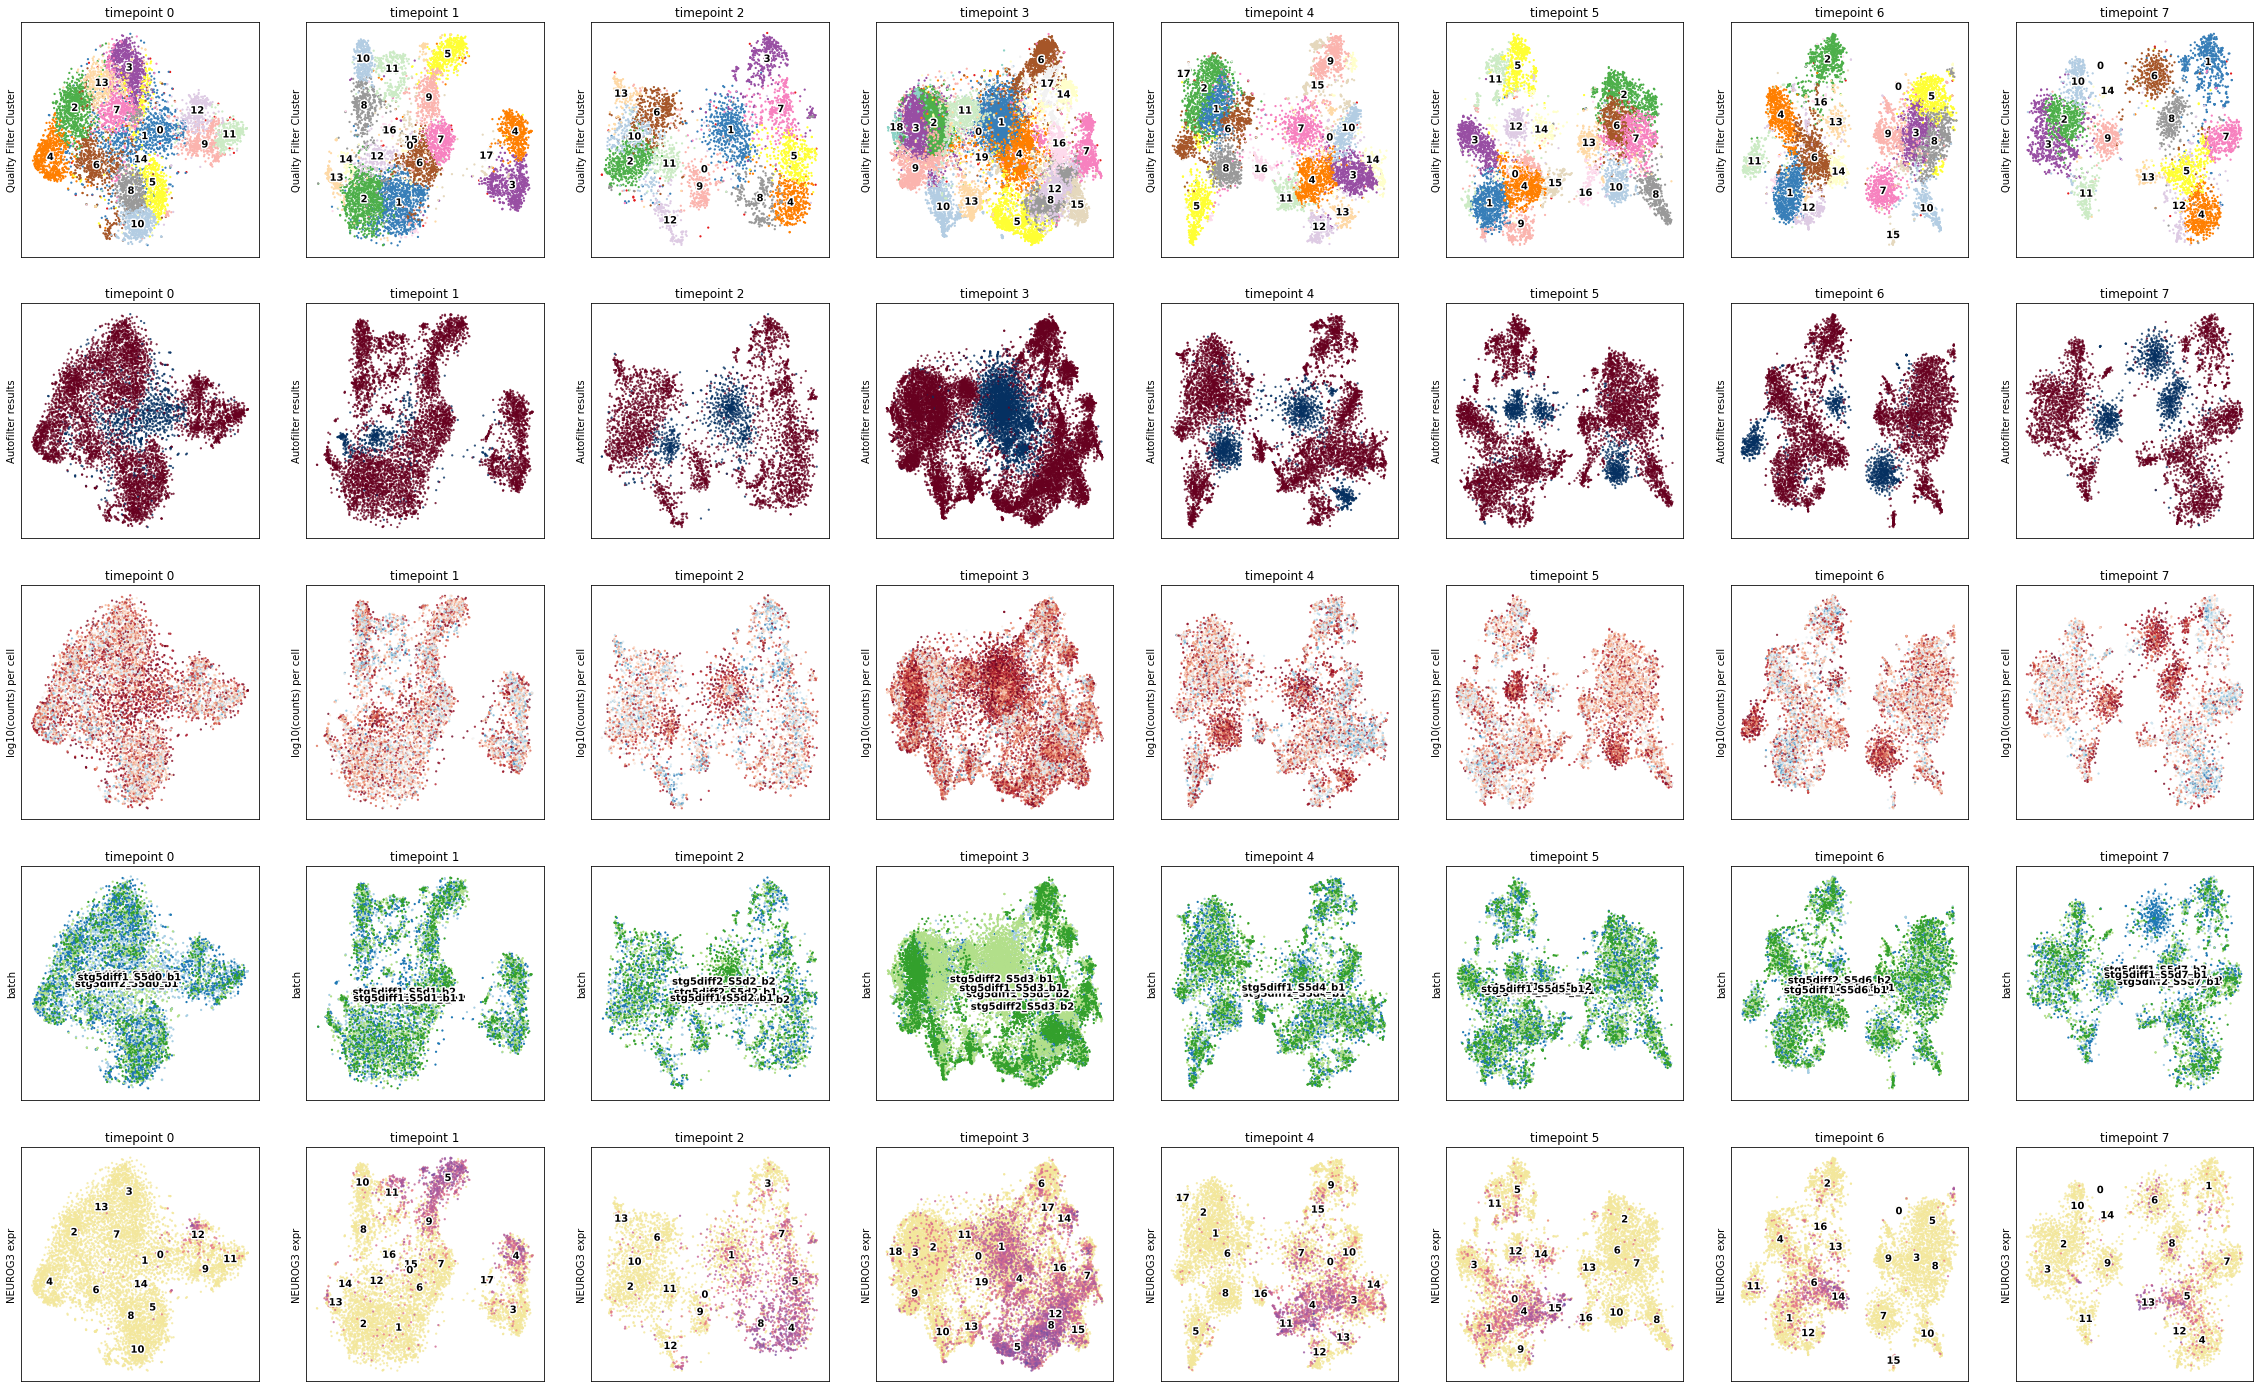

In [9]:
vis.plot_auto_qual_filter_by_time_point(ds_dict=tds, show_genes= ['NEUROG3'])

### Verify the automated filter


In [10]:
manual_changes = defaultdict(lambda : dict(), {
                        3: {'force_false':  [11,], },
                        })

for tp in tds.keys():
    _tds = tds[tp]
    _tds.ca['__Filter2__Verified_quality'] = cgm.update_cluster_based_filter(
            _tds.ca['__Filter1__Automated_quality'],
            _tds.ca['QualFilterLabels'],
            **manual_changes[tp])
    

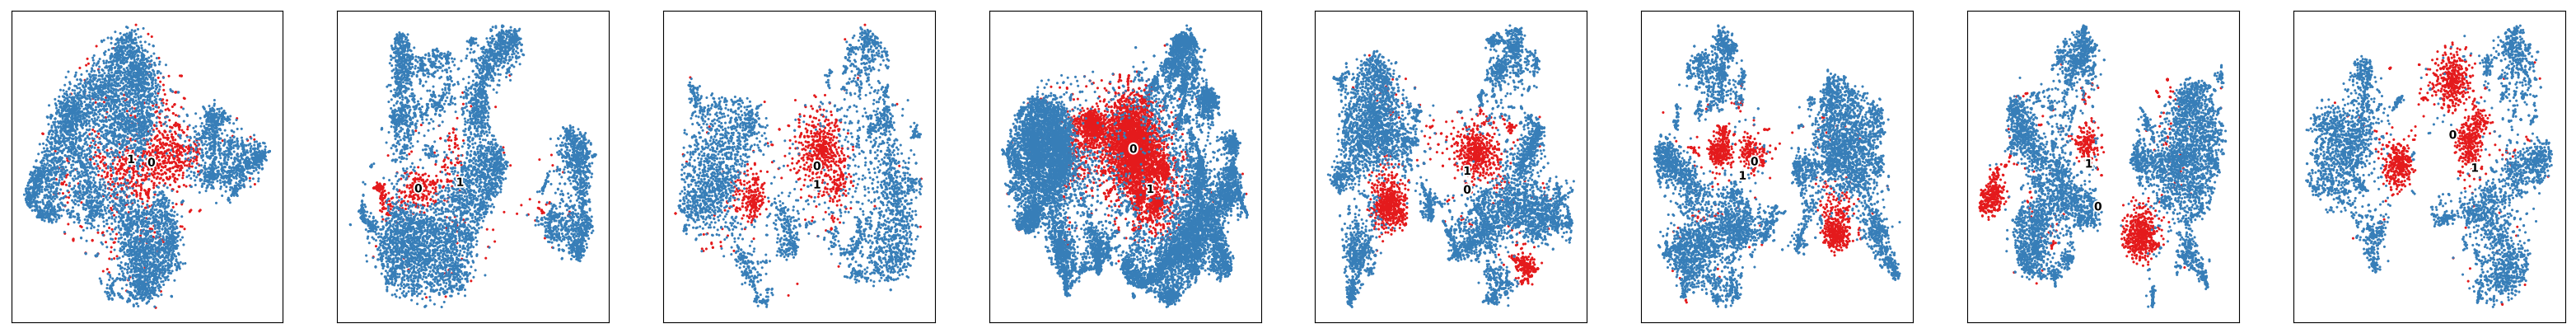

In [11]:
vis.plot_attr_by_time_point(tds, '__Filter2__Verified_quality')

In [12]:
cgm.merge_split_dataset_filter(tds, ds, '__Filter1__Automated_quality')
cgm.merge_split_dataset_filter(tds, ds, '__Filter2__Verified_quality')

In [15]:
train_filter = ds.ca['__Filter2__Verified_quality'] > 0
train_cells = np.where(train_filter)[0]

In [16]:

seed = 78371972

cga.highvar_pca(ds, ds.vals, namespace='Raw', seed=seed, train_cells=train_cells)

cluster_labels = cga.mknn_leiden_labels(ds.ca['RawHighVarPCA'][train_cells], train_filter,
                                        nn_k=250, clustering_resolution=3.0, seed=seed)

ds.ca['__Labels1__GlobalQualFilteringClusters'] = cluster_labels.original

### Quality filter, using clusters called on entire dataset

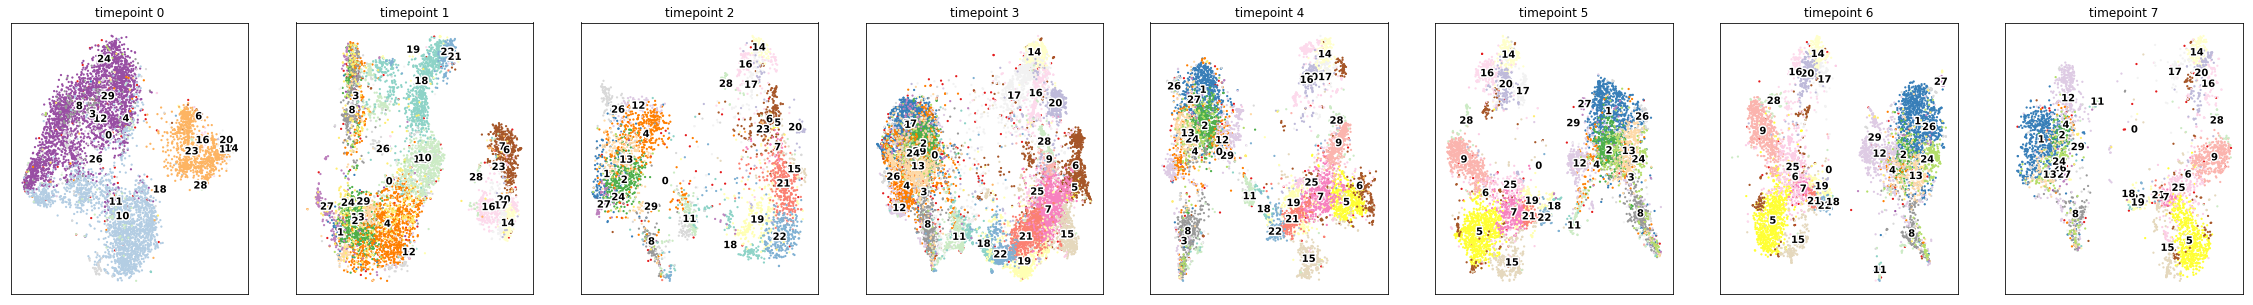

In [17]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels1__GlobalQualFilteringClusters'][train_cells],
                                            index=ds.ca.CellID[train_cells]), 
                          int_categories=True, min_elements_for_label=5)

In [18]:
# # Cluster 17 contains a lot of cells with lower counts

# ds.ca['__Filter3__Global_quality'] = cgm.update_cluster_based_filter(
#             ds.ca['__Filter2__Verified_quality'],
#             ds.ca['__Labels1__GlobalQualFilteringClusters'],
#             force_false = (17,))



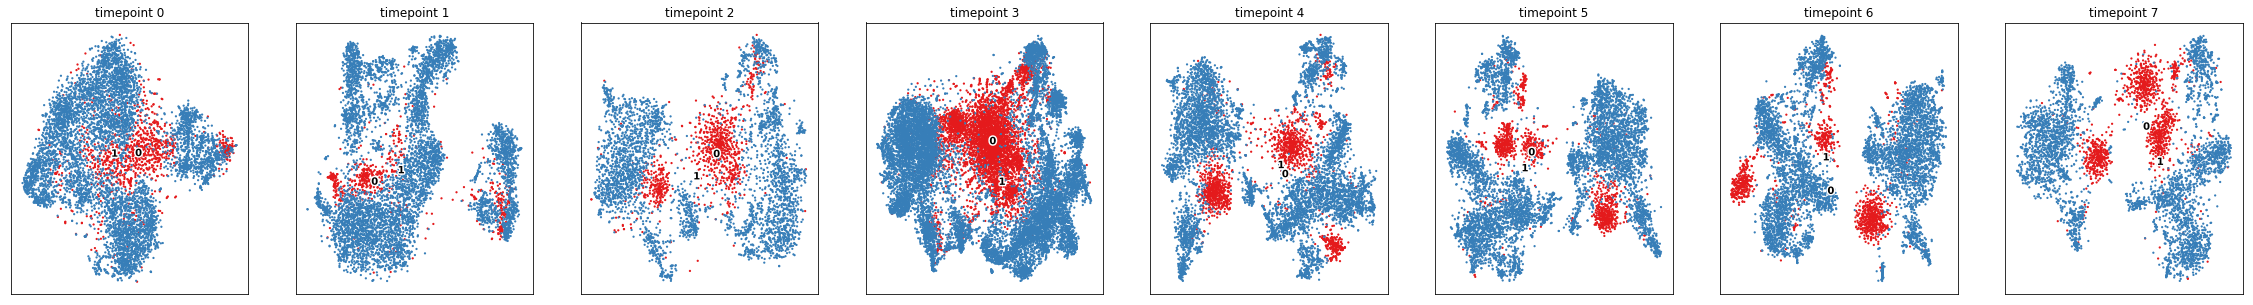

In [19]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Filter3__Global_quality'],
                                            index=ds.ca.CellID), 
                          int_categories=True)

In [20]:
seed = 8378929
final_train_filter = ds.ca['__Filter3__Global_quality'] > 0
final_train_cells = np.where(final_train_filter)[0]

In [21]:

cga.highvar_pca(ds, ds.vals, namespace='Final', seed=seed, train_cells=final_train_cells)


global_cluster_labels = cga.mknn_leiden_labels(ds.ca['FinalHighVarPCA'][final_train_cells], final_train_filter,
                                        nn_k=250, clustering_resolution=3.0, seed=seed)

ds.ca['__Labels2__Clusters'] = global_cluster_labels.original


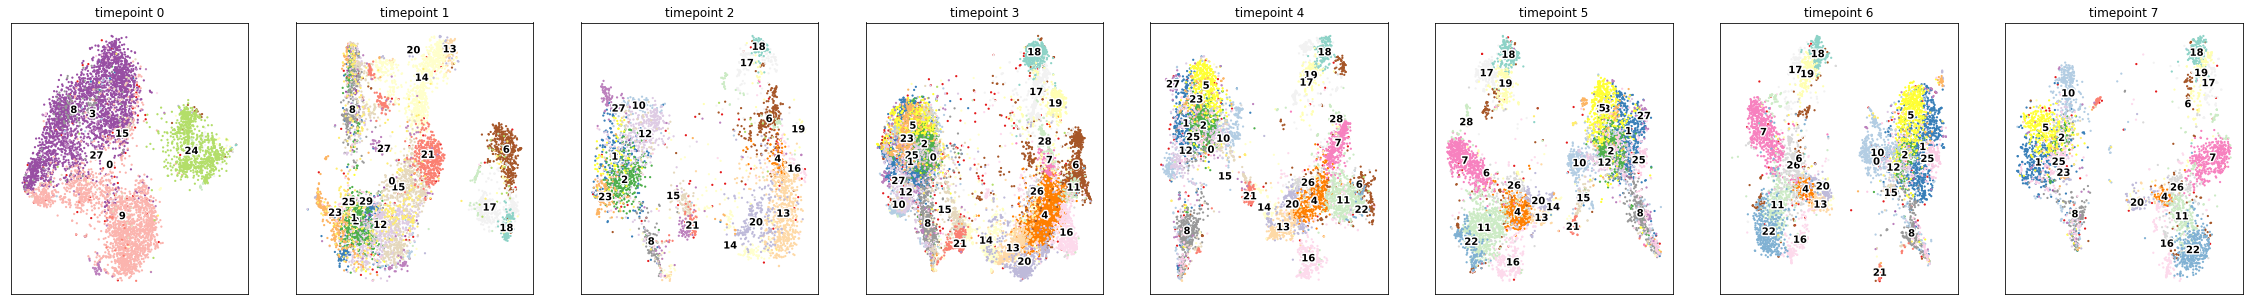

In [22]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels2__Clusters'][final_train_cells],
                                            index=ds.ca.CellID[final_train_cells]), 
                          int_categories=True)


In [23]:
# Cluster 24 contains all the premature endocrine cells from day 0
_labels_to_refine = (24,)
_cluster_labels = ds.ca['__Labels2__Clusters']



refined = cga.recluster_label(ds.ca['FinalHighVarPCA'], _cluster_labels, _labels_to_refine,
                              nn_k=250, min_cluster_size=10, seed=1988444, clustering_resolution=1.0)
ds.ca['__Labels3__RefinedClusters'] = refined.original
    


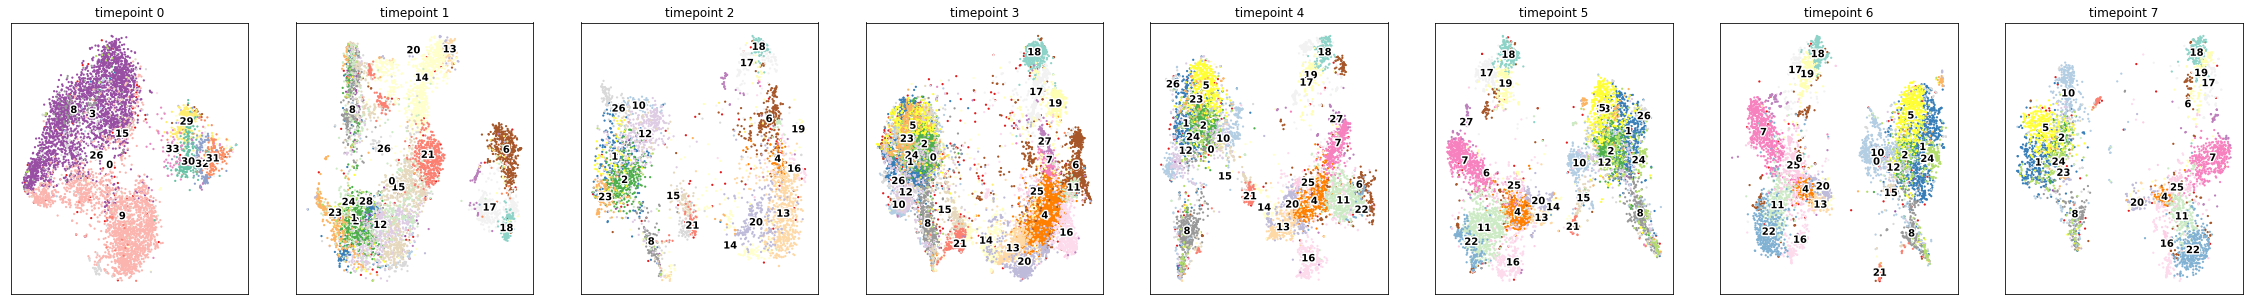

In [24]:
vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels3__RefinedClusters'] [final_train_cells],
                                            index=ds.ca.CellID[final_train_cells]), 
                          int_categories=True)

### Cluster interpretation

In [25]:
pb_labels = cgm.CellLabels(ds.ca['__Labels3__RefinedClusters'])
cluster_pseudobulk = cga.pseudobulk_from_label(ds, pb_labels)
cluster_pseudobulk_z = ((cluster_pseudobulk - cluster_pseudobulk.mean())/cluster_pseudobulk.std()).fillna(0.0)


In [26]:
autolabel_enrichment = utils.load_df(f'../data/clustering/stage5.autolabels.df.npz')

autolabel_corr = pd.DataFrame(utils.two_array_corr((autolabel_enrichment > 0).astype(float).values,
                                                   cluster_pseudobulk_z.T.loc[autolabel_enrichment.index].values),
                                 columns = autolabel_enrichment.columns,
                                 index=cluster_pseudobulk_z.T.columns)

In [27]:
autolabel_calls = autolabel_corr.idxmax(1)
autolabel_calls = autolabel_calls.to_dict()
autolabel_calls[0] = ''

#print(pd.Series(autolabel_calls))

ann_labels = cgm.CellLabels(np.array([autolabel_calls[li] for li in pb_labels.original]), null_label='')

ds.ca['__Labels4__AnnotatedLabels'] = ann_labels.original
 

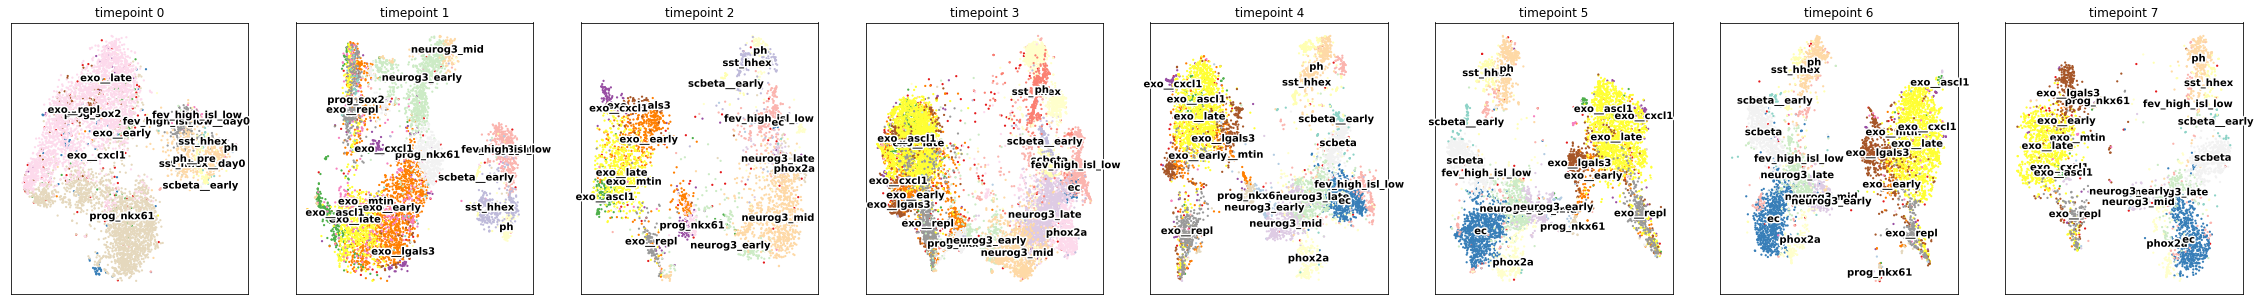

In [28]:

vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels4__AnnotatedLabels'][final_train_cells],
                                            index=ds.ca.CellID[final_train_cells]), 
                          int_categories=False, min_elements_for_label=10)


In [29]:
Counter(ds.ca['__Labels4__AnnotatedLabels'])

Counter({'prog_sox2': 2801,
         'fev_high_isl_low__day0': 286,
         'prog_nkx61': 3358,
         '': 13461,
         'exo__cxcl1': 688,
         'ph__pre': 589,
         'sst_hhex': 1649,
         'exo__repl': 2195,
         'exo__late': 9456,
         'sst_hhex__day0': 110,
         'fev_high_isl_low': 2293,
         'ph': 3023,
         'scbeta__early': 477,
         'exo__early': 3601,
         'neurog3_late': 3394,
         'exo__lgals3': 1976,
         'neurog3_early': 1702,
         'neurog3_mid': 3226,
         'phox2a': 1665,
         'exo__mtin': 414,
         'exo__ascl1': 1001,
         'ec': 3034,
         'scbeta': 2282})

### Classifier training and prediction to recover cells that were removed by the quality filter

In [30]:
ann_labels = cgm.CellLabels(ds.ca['__Labels4__AnnotatedLabels'], null_label="")

classifier_labels = cga.update_labels_with_classifier(ds, ann_labels,
        do_not_classify_filter = (((ds.ca.CellDay==0)) & (ds.ca['__Filter3__Global_quality']==0)).astype(int),
        recovery_classification_threshold=0.66)

ds.ca['__Labels5__ClassifierLabels_detailed'] = classifier_labels.original
ds.ca['__Labels6__ClassifierLabels'] = np.array([s.split('__')[0] for s in ds.ca['__Labels5__ClassifierLabels_detailed']])

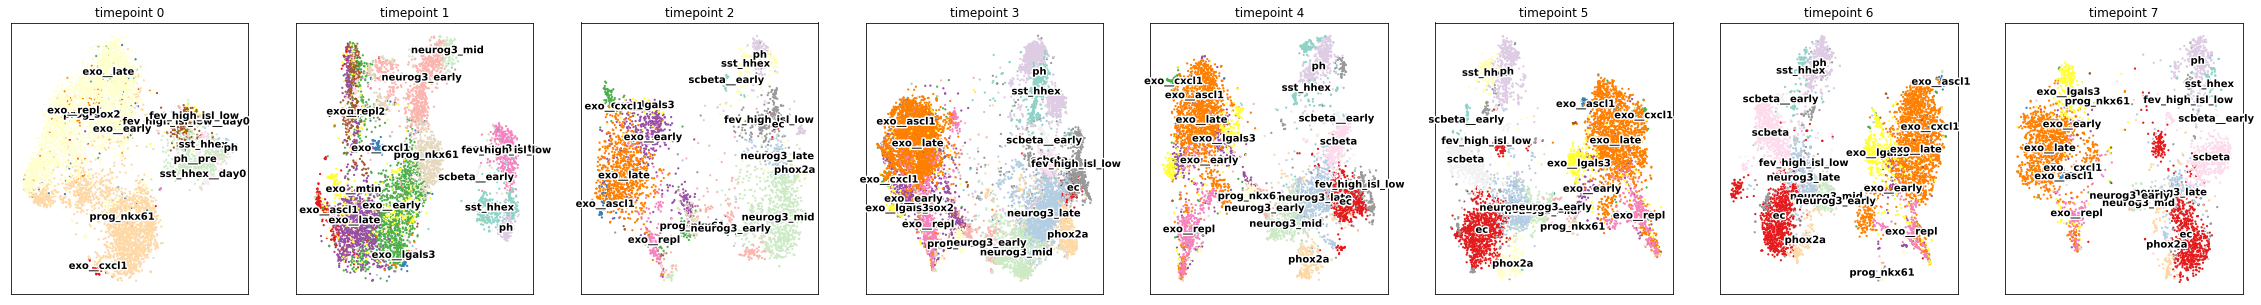

In [31]:
classifier_labels = cgm.CellLabels(ds.ca['__Labels5__ClassifierLabels_detailed'], null_label='')

vis.plot_cat_by_time_point(tds, pd.Series(ds.ca['__Labels5__ClassifierLabels_detailed'][classifier_labels.is_labelled],
                                            index=ds.ca.CellID[classifier_labels.is_labelled]), 
                          int_categories=False, min_elements_for_label=10)



### Copy to a file containing only the unfiltered data

In [32]:
attributes_to_copy = [
    ('CellID', 'CellID'),
    ('CellBatch', 'CellBatch'),
    ('CellDay', 'CellDay'),
    ('CellFlask', 'CellFlask'),
    ('_Valid', '_Valid'),
    ('__Labels6__ClassifierLabels', 'Labels'),
    ('__Labels5__ClassifierLabels_detailed', 'DetailedLabels'),
    ('__Filter3__Global_quality', '_TrainFilter'),
    ]

%rm ../data/complete_processing/*.loom
%mkdir ../data/complete_processing/
min_cells_per_valid_gene = 10

new_loom_fn = f'../data/complete_processing/stage5.processed.loom'

f_cells = np.where(ds.ca.__Labels6__ClassifierLabels != '')[0]
loompy.create(new_loom_fn, {'': ds.vals[:, f_cells]},
              {'Gene': ds.ra.Gene,
               '_Valid': (ds.vals[:, f_cells].sum(1).A.ravel() > min_cells_per_valid_gene)
                  },
              {new_attr_name: ds.ca[old_attr_name][f_cells] for old_attr_name, new_attr_name in attributes_to_copy},
             )


## Output pseudobulk values for combinations of labels and time

In [33]:
new_loom_fn = f'../data/complete_processing/stage5.processed.loom'
pds = loompy.connect(new_loom_fn)
pds.vals = sp.sparse.csr_matrix(pds.layers[""][:, :])



In [34]:
time_labels = cgm.CellLabels(np.array([f'{tp}__{cl}' for tp,cl in zip(pds.ca.CellDay, pds.ca.Labels)]), null_label="")
full_labels = cgm.CellLabels(pds.ca.Labels, null_label="")
detailed_labels = cgm.CellLabels(pds.ca.DetailedLabels, null_label="")

for _labels, label_name in [(time_labels, 'time_labels'),
                        (full_labels, 'labels'),
                        (detailed_labels, 'det_labels')]:
    

    tp_pb = cga.pseudobulk_from_label(pds, _labels, norm_total=10**6)
    tp_expr = cga.expressed_fraction_from_label(pds, _labels)
    
    utils.save_df(tp_pb, f'../data/complete_processing/stage5.{label_name}.pseudobulk_tpm.df.npz')
    utils.save_df(tp_expr, f'../data/complete_processing/stage5.{label_name}.expr_frac.df.npz')
    
    

### Make the tSNE

In [35]:
# Train PCA with cells that were never filter, and week >0
train_cells = np.where((ds.ca.CellDay > 0) & (ds.ca._TrainFilter > 0))[0]

normalizer = cgm.CountsNormalizer()
normalizer.fit(pds.vals)

features = cgm.FeatureSelection()
features.fit(pds, pds.vals, cells=train_cells)
n_cells = len(normalizer.totals)

_valid_genes = pds.ra._Valid
_valid_genes[np.where(np.isin(pds.ra.Gene, list(cell_cycle_set)))[0]] = 0

n_hv = 2000
n_pcs = 25

genes = features.select_genes(n_genes=n_hv, valid_genes=_valid_genes.astype(bool))
high_var_pca = cgm.PCAProjection(genes=genes, max_n_components=n_pcs)
high_var_pca.fit(pds.vals, normalizer=normalizer, cells=train_cells)

high_var_pca_transformed = high_var_pca.transform(pds.vals, normalizer=normalizer)

pca_proj = pd.DataFrame(high_var_pca_transformed, index=pds.ca.CellID)
utils.save_df(pca_proj, 'stage5.pca_proj.n_hvgs{n_hv}.n_pcs{n_pcs}.nody0.df.npz')

# execute
# scripts/run_tsne.py stage5.pca_proj.n_hvgs{n_hv}.n_pcs{n_pcs}.nowk0.df.npz stage5.tsne_proj.df.npz -s 78391126 -p 200 -i 100000 -r 25 -v

pds.ca['TSNE'] = utils.load_df('stage5.tsne_proj.df.npz').values



In [36]:
# pds.close()